In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

from pymongo import MongoClient
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField, FloatType
from pyspark.sql.functions import col, year, month, weekofyear, dayofmonth, hour, to_date, to_timestamp
from pyspark.sql.functions import avg, split, size

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')

import cassandra

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create a SparkSession
#spark = SparkSession.builder.appName("TextProcessing").getOrCreate()
spark = SparkSession.builder \
    .appName("TextProcessing") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:2.4.2") \
    .getOrCreate()
# Set the log level to "ERROR"
spark.sparkContext.setLogLevel("ERROR")
# A JSON dataset is pointed to by path.
# Move the 'people.json' file to HDFS path '/user1'
path = "/user1/Trump_Tweets.json"
twitterDF = spark.read.json(path)

2023-05-25 00:29:52,485 WARN util.Utils: Your hostname, muhammad-Vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
2023-05-25 00:29:52,488 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/usr/local/spark-3.1.3-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hduser/.ivy2/cache
The jars for the packages stored in: /home/hduser/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5d2c83c8-0afb-42f3-8bde-6deab0716ea6;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;2.4.2 in central
	found org.mongodb#mongo-java-driver;3.12.5 in central
:: resolution report :: resolve 889ms :: artifacts dl 34ms
	:: modules in use:
	org.mongodb#mongo-java-driver;3.12.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;2.4.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0 

In [3]:
twitterDF.printSchema()

root
 |-- Client: string (nullable = true)
 |-- Client Simplified: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Tweet: string (nullable = true)



In [4]:
twitterDF.show()

+-------------------+-------------------+----------+-----------+--------------------+
|             Client|  Client Simplified|      Date|       Time|               Tweet|
+-------------------+-------------------+----------+-----------+--------------------+
| Twitter for iPhone| Twitter for iPhone|01/27/2017| 6:46:22 PM| I promise that o...|
| Twitter for iPhone| Twitter for iPhone|01/27/2017| 5:00:47 PM| Congratulations ...|
| Twitter for iPhone| Twitter for iPhone|01/27/2017| 3:20:15 PM| Statement on Int...|
| Twitter for iPhone| Twitter for iPhone|01/27/2017|11:30:29 AM| .@VP Mike Pence ...|
| Twitter for iPhone| Twitter for iPhone|01/27/2017|11:27:02 AM| The #MarchForLif...|
|Twitter for Android|Twitter for Android|01/27/2017| 8:19:10 AM| Mexico has taken...|
|Twitter for Android|Twitter for Android|01/27/2017| 8:12:52 AM| Look forward to ...|
| Twitter for iPhone| Twitter for iPhone|01/26/2017| 6:53:37 PM| Miami-Dade Mayor...|
| Twitter for iPhone| Twitter for iPhone|01/26/2017| 6

In [5]:
# Select specific columns
selected_columns = ["Date", "Time", "Tweet"]
twitterDF = twitterDF.select(*selected_columns)

In [6]:
twitterDF.show()

+----------+-----------+--------------------+
|      Date|       Time|               Tweet|
+----------+-----------+--------------------+
|01/27/2017| 6:46:22 PM| I promise that o...|
|01/27/2017| 5:00:47 PM| Congratulations ...|
|01/27/2017| 3:20:15 PM| Statement on Int...|
|01/27/2017|11:30:29 AM| .@VP Mike Pence ...|
|01/27/2017|11:27:02 AM| The #MarchForLif...|
|01/27/2017| 8:19:10 AM| Mexico has taken...|
|01/27/2017| 8:12:52 AM| Look forward to ...|
|01/26/2017| 6:53:37 PM| Miami-Dade Mayor...|
|01/26/2017| 6:45:28 PM| Will be intervie...|
|01/26/2017| 2:21:17 PM| Spoke at the Con...|
|01/26/2017| 8:55:03 AM| of jobs and comp...|
|01/26/2017| 8:51:46 AM| The U.S. has a 6...|
|01/26/2017| 6:04:24 AM| Ungrateful TRAIT...|
|01/25/2017| 9:48:25 PM| Interview with D...|
|01/25/2017| 9:45:32 PM| "@romoabcnews: ....|
|01/25/2017| 9:14:56 PM| As your Presiden...|
|01/25/2017| 7:03:33 PM| Beginning today,...|
|01/25/2017| 5:05:59 PM| I will be interv...|
|01/25/2017| 7:17:01 AM| I will be

In [7]:
# Define a function for text processing
def process_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs using regular expressions
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove mentions using regular expressions
    text = re.sub(r"@\w+", "", text)
    
    # Remove hashtags using regular expressions
    text = re.sub(r"#\w+", "", text)
    
    # Remove special characters and punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Register the text processing function as a UDF
process_text_udf = udf(process_text, StringType())

# Apply the text processing UDF to the "Tweet" column
df = twitterDF.withColumn("clean_tweet", process_text_udf(twitterDF["Tweet"]))

In [8]:
# Get the current column names
current_columns = df.columns

# Create a new DataFrame with lowercase column names
df = df.toDF(*[col.lower() for col in current_columns])

In [9]:
df.show()

+----------+-----------+--------------------+--------------------+
|      date|       time|               tweet|         clean_tweet|
+----------+-----------+--------------------+--------------------+
|01/27/2017| 6:46:22 PM| I promise that o...|i promise that ou...|
|01/27/2017| 5:00:47 PM| Congratulations ...|congratulations s...|
|01/27/2017| 3:20:15 PM| Statement on Int...|statement on inte...|
|01/27/2017|11:30:29 AM| .@VP Mike Pence ...|mike pence will b...|
|01/27/2017|11:27:02 AM| The #MarchForLif...|the is so importa...|
|01/27/2017| 8:19:10 AM| Mexico has taken...|mexico has taken ...|
|01/27/2017| 8:12:52 AM| Look forward to ...|look forward to s...|
|01/26/2017| 6:53:37 PM| Miami-Dade Mayor...|miamidade mayor d...|
|01/26/2017| 6:45:28 PM| Will be intervie...|will be interview...|
|01/26/2017| 2:21:17 PM| Spoke at the Con...|spoke at the cong...|
|01/26/2017| 8:55:03 AM| of jobs and comp...|of jobs and compa...|
|01/26/2017| 8:51:46 AM| The U.S. has a 6...|the us has a 60 b

In [10]:
# Connect to the MongoDB server
client = MongoClient('mongodb://localhost:27017')  # Replace 'localhost' with your MongoDB server address

# Access the database and collection
db = client['sentiment']  # Replace 'sentiment' with your database name
collection = db['sentiment_collection']  # Replace 'sentiment_collection' with your collection name

# Clear the existing documents in the collection
collection.delete_many({})

# Convert DataFrame to RDD and collect all rows
rows = df.rdd.collect()  # or new_df.rdd.collect() if using 'new_df'

# Insert the dataset into the collection
for row in rows:
    collection.insert_one(row.asDict())

# Close the MongoDB connection
# client.close()


In [11]:
# Retrieve data from MongoDB collection, excluding the "_id" field
data = list(collection.find({}, {"_id": 0}))

# Create a DataFrame from the retrieved data
df = spark.createDataFrame(data)

# Apply sentiment analysis using NLTK
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(tweet):
    sentiment_score = analyzer.polarity_scores(tweet)['compound']
    
    if sentiment_score > 0:
        sentiment_label = "Positive"
    elif sentiment_score < 0:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"
    
    return sentiment_score, sentiment_label

# Define the schema for the sentiment analysis result
sentiment_schema = StructType([
    StructField("sentiment_score", FloatType(), nullable=False),
    StructField("sentiment_label", StringType(), nullable=False)
])

sentiment_udf = udf(analyze_sentiment, sentiment_schema)

# Apply sentiment analysis and create new columns for sentiment score and label
df = df.withColumn("sentiment", sentiment_udf(df["clean_tweet"]))
df = df.withColumn("sentiment_score", df["sentiment"]["sentiment_score"])
df = df.withColumn("sentiment_label", df["sentiment"]["sentiment_label"])

# Select the desired columns
selected_columns = ["date", "time", "clean_tweet", "sentiment_score", "sentiment_label"]
df = df.select(*selected_columns)

# Show the DataFrame with sentiment analysis results
df.show()

# Close the MongoDB connection
#client.close()


+----------+-----------+--------------------+---------------+---------------+
|      date|       time|         clean_tweet|sentiment_score|sentiment_label|
+----------+-----------+--------------------+---------------+---------------+
|01/27/2017| 6:46:22 PM|i promise that ou...|         0.3182|       Positive|
|01/27/2017| 5:00:47 PM|congratulations s...|         0.5994|       Positive|
|01/27/2017| 3:20:15 PM|statement on inte...|            0.0|        Neutral|
|01/27/2017|11:30:29 AM|mike pence will b...|         0.4019|       Positive|
|01/27/2017|11:27:02 AM|the is so importa...|         0.6207|       Positive|
|01/27/2017| 8:19:10 AM|mexico has taken ...|         0.0552|       Positive|
|01/27/2017| 8:12:52 AM|look forward to s...|        -0.1779|       Negative|
|01/26/2017| 6:53:37 PM|miamidade mayor d...|         0.5106|       Positive|
|01/26/2017| 6:45:28 PM|will be interview...|         0.4939|       Positive|
|01/26/2017| 2:21:17 PM|spoke at the cong...|         0.2023|   

In [12]:
# Group by sentiments and count the number of tweets in each sentiment category
sentiment_counts = df.groupBy("sentiment_label").count().withColumnRenamed("count", "tweet_count")

# Show the resulting DataFrame
sentiment_counts.show()

+---------------+-----------+
|sentiment_label|tweet_count|
+---------------+-----------+
|       Positive|      17876|
|        Neutral|       5255|
|       Negative|       7254|
+---------------+-----------+



In [13]:
#Convert date column to DateType
df = df.withColumn("date", to_date(df["date"], "MM/dd/yyyy"))

#Convert time column to TimestampType
df = df.withColumn("time", to_timestamp(df["time"], "h:mm:ss a"))

#Extract date components
df = df.withColumn("year",year(col("Date")))
df = df.withColumn("month",month(col("Date")))
df = df.withColumn("week",weekofyear(col("Date")))
df = df.withColumn("day",dayofmonth(col("Date")))

#Extract time components
df = df.withColumn("hour", hour(col("Time")))

df.show()

+----------+-------------------+--------------------+---------------+---------------+----+-----+----+---+----+
|      date|               time|         clean_tweet|sentiment_score|sentiment_label|year|month|week|day|hour|
+----------+-------------------+--------------------+---------------+---------------+----+-----+----+---+----+
|2017-01-27|1970-01-01 18:46:22|i promise that ou...|         0.3182|       Positive|2017|    1|   4| 27|  18|
|2017-01-27|1970-01-01 17:00:47|congratulations s...|         0.5994|       Positive|2017|    1|   4| 27|  17|
|2017-01-27|1970-01-01 15:20:15|statement on inte...|            0.0|        Neutral|2017|    1|   4| 27|  15|
|2017-01-27|1970-01-01 11:30:29|mike pence will b...|         0.4019|       Positive|2017|    1|   4| 27|  11|
|2017-01-27|1970-01-01 11:27:02|the is so importa...|         0.6207|       Positive|2017|    1|   4| 27|  11|
|2017-01-27|1970-01-01 08:19:10|mexico has taken ...|         0.0552|       Positive|2017|    1|   4| 27|   8|
|

In [14]:
# Calculate average tweets per week
weekly_tweets = df.groupBy("year", "week").count()
average_tweets_per_week = weekly_tweets.groupBy("year").agg(avg("count").alias("average_tweets_per_week"))
average_tweets_per_week = average_tweets_per_week.orderBy("year")
average_tweets_per_week.show()

# Calculate average length per tweet (by word)
df_with_word_count = df.withColumn("word_count", size(split("clean_tweet", " ")))
average_length_per_tweet = df_with_word_count.agg(avg("word_count").alias("average_length_per_tweet"))
average_length_per_tweet.show()


+----+-----------------------+
|year|average_tweets_per_week|
+----+-----------------------+
|2009|                    2.0|
|2010|     2.8979591836734695|
|2011|                  15.48|
|2012|      67.90384615384616|
|2013|      156.6153846153846|
|2014|     111.38461538461539|
|2015|      142.0754716981132|
|2016|      79.71698113207547|
|2017|                   38.2|
+----+-----------------------+



+------------------------+
|average_length_per_tweet|
+------------------------+
|       14.43422741484285|
+------------------------+



In [15]:
spark.conf.set("spark.cassandra.connection.host", "127.0.0.1")  
spark.conf.set("spark.cassandra.connection.port", "9042")  

In [16]:
#df.write \
    #.format("org.apache.spark.sql.cassandra") \
    #.options(table="date_extracted_db", keyspace="my_keyspace") \
    #.mode("Append") \
    #.save()

In [17]:
mongodb_df = spark.read.text('/user1/output-Load.txt')
cassandra_df = spark.read.text('/user1/outputLoad.txt')

In [18]:
# Convert PySpark DataFrame to Pandas DataFrame
mongodb_df = mongodb_df.toPandas()
cassandra_df = cassandra_df.toPandas()

# Rename the column and drop the first row
mongodb_df.columns = ['value']
mongodb_df = mongodb_df.iloc[1:]
cassandra_df.columns = ['value']
cassandra_df = cassandra_df.iloc[1:]

# Extract the metrics name and values
mongodb_df['metrics'] = mongodb_df['value'].apply(lambda x: x.split(',')[1].strip())
mongodb_df['mongodb_result'] = mongodb_df['value'].apply(lambda x: x.split(',')[2].strip())
cassandra_df['cassandra_result'] = cassandra_df['value'].apply(lambda x: x.split(', ')[-1].strip())

# Drop the original 'value' column
mongodb_df = mongodb_df.drop('value', axis=1)
cassandra_df = cassandra_df.drop('value', axis=1)

# Merge the Cassandra DataFrame with the MongoDB DataFrame
merged_df = pd.concat([mongodb_df, cassandra_df], axis=1)

# Display the merged DataFrame
print(merged_df.head)

<bound method NDFrame.head of                       metrics      mongodb_result    cassandra_result
1                 RunTime(ms)                5762                1551
2         Throughput(ops/sec)  173.55085039916696   644.7453255963894
3                       Count                   2                   2
4                    Time(ms)                  48                  12
5                     Time(%)  0.8330440819160014  0.7736943907156674
6                       Count                   0                   0
7                    Time(ms)                   0                   0
8                     Time(%)                 0.0                 0.0
9                       Count                   2                   2
10                   Time(ms)                  48                  12
11                    Time(%)  0.8330440819160014  0.7736943907156674
12                 Operations                   1                   1
13         AverageLatency(us)              7982.0           

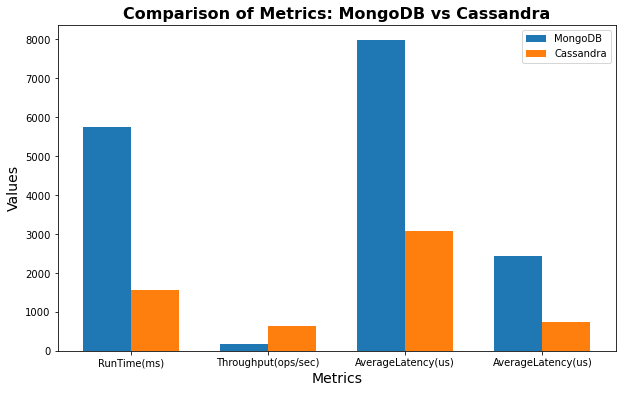

In [19]:
# Create a subset of the DataFrame with the important metrics
important_metrics = ['RunTime(ms)', 'AverageLatency(us)','Throughput(ops/sec)']
comparison_df = merged_df[merged_df['metrics'].isin(important_metrics)]

# Convert the result columns to numeric values
comparison_df['mongodb_result'] = pd.to_numeric(comparison_df['mongodb_result'])
comparison_df['cassandra_result'] = pd.to_numeric(comparison_df['cassandra_result'])

# Plot the differences using a bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(comparison_df['metrics']))
plt.bar(x - bar_width/2, comparison_df['mongodb_result'], bar_width, label='MongoDB')
plt.bar(x + bar_width/2, comparison_df['cassandra_result'], bar_width, label='Cassandra')
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Metrics: MongoDB vs Cassandra', fontsize=16, fontweight='bold')
plt.xticks(x, comparison_df['metrics'])
plt.legend()
plt.show()

In [20]:
from cassandra.cluster import Cluster
from cassandra.query import dict_factory
import pandas as pd

# Connect to the Cassandra cluster without authentication
cluster = Cluster(contact_points=['127.0.0.1'], port=9042)
session = cluster.connect('my_keyspace')

# Set the row factory to return results as dictionaries
session.row_factory = dict_factory

# Define the SQL query to select all data from the specified table
sql_query = "SELECT * FROM {}.{};".format('my_keyspace', 'date_extracted_db')

# Create an empty list to store the rows
rows = []

# Execute the SQL query
result_set = session.execute(sql_query)

# Fetch all pages of results
for row in result_set:
    rows.append(row)

# Create a DataFrame from the collected rows
df = pd.DataFrame(rows)

# Reset the index of the DataFrame and fill any missing values with NaN
df = df.reset_index(drop=True).fillna(pd.np.nan)



In [21]:
df.head()

,date,time,clean_tweet,day,hour,month,sentiment_label,sentiment_score,week,year
0,2015-12-04,1969-12-31 23:55:07,we cant take 8 years of hilary or 8 years of e...,4,0,12,Neutral,0.0000,49,2015
1,2015-12-04,1969-12-31 23:57:06,great job on oreilly stay who you are its refr...,4,0,12,Positive,0.6249,49,2015
2,2015-12-04,1970-01-01 00:00:49,show em how its done in raleigh tomorrow presi...,4,1,12,Neutral,0.0000,49,2015
3,2015-12-04,1970-01-01 00:01:41,your hand must be tired from all the crippled ...,4,1,12,Positive,0.6597,49,2015
4,2015-12-04,1970-01-01 00:04:39,as a professional handicapper is a 35 favorite...,4,1,12,Positive,0.4588,49,2015


In [22]:
df.shape

(30384, 10)

In [29]:
from datetime import datetime

# Remove the date from time feature and keep only the time value
def extract_time_only(date_time_list):
    time_only_list = []
    for date_time_obj in date_time_list:
        # Extract the time portion
        time_only_str = date_time_obj.strftime("%H:%M:%S")
        # Append the time-only string to the result list
        time_only_list.append(time_only_str)
    return time_only_list

df['time'] = extract_time_only(df['time'])

# Restructure the dataset by the appropriate feature order
df = df[['date', 'year', 'month', 'week', 'day', 'time', 'hour', 'clean_tweet', 'sentiment_score', 'sentiment_label']]

In [30]:
df.head()

,date,year,month,week,day,time,hour,clean_tweet,sentiment_score,sentiment_label
0,2015-12-04,2015,12,49,4,23:55:07,0,we cant take 8 years of hilary or 8 years of e...,0.0000,Neutral
1,2015-12-04,2015,12,49,4,23:57:06,0,great job on oreilly stay who you are its refr...,0.6249,Positive
2,2015-12-04,2015,12,49,4,00:00:49,1,show em how its done in raleigh tomorrow presi...,0.0000,Neutral
3,2015-12-04,2015,12,49,4,00:01:41,1,your hand must be tired from all the crippled ...,0.6597,Positive
4,2015-12-04,2015,12,49,4,00:04:39,1,as a professional handicapper is a 35 favorite...,0.4588,Positive


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30384 entries, 0 to 30383
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             30384 non-null  object 
 1   year             30384 non-null  int64  
 2   month            30384 non-null  int64  
 3   week             30384 non-null  int64  
 4   day              30384 non-null  int64  
 5   time             30384 non-null  object 
 6   hour             30384 non-null  int64  
 7   clean_tweet      30384 non-null  object 
 8   sentiment_score  30384 non-null  float64
 9   sentiment_label  30384 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 2.3+ MB


In [33]:
from cassandra.util import Date

#Create a custom conversion function to handle the conversion of cassandra.util.Date objects
def convert_date(date):
    if isinstance(date, Date):
        return pd.Timestamp(date.date())
    return pd.NaT

#Apply the custom conversion function to the 'date' column
df['date'] = df['date'].apply(convert_date)


In [36]:
df.head()

,year,month,week,day,time,hour,clean_tweet,sentiment_score,sentiment_label
date,,,,,,,,,
2015-12-04,2015,12,49,4,23:55:07,0,we cant take 8 years of hilary or 8 years of e...,0.0000,Neutral
2015-12-04,2015,12,49,4,23:57:06,0,great job on oreilly stay who you are its refr...,0.6249,Positive
2015-12-04,2015,12,49,4,00:00:49,1,show em how its done in raleigh tomorrow presi...,0.0000,Neutral
2015-12-04,2015,12,49,4,00:01:41,1,your hand must be tired from all the crippled ...,0.6597,Positive
2015-12-04,2015,12,49,4,00:04:39,1,as a professional handicapper is a 35 favorite...,0.4588,Positive


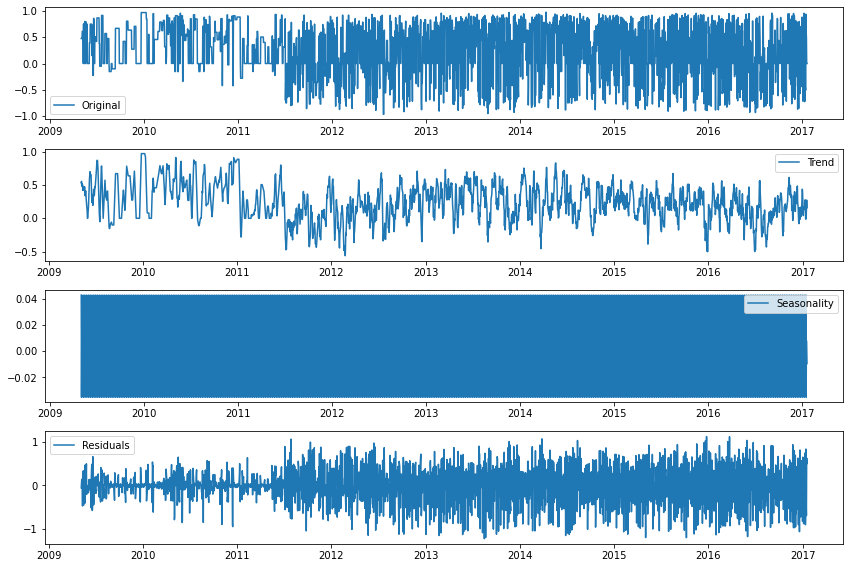

2017-01-21    0.183018
2017-01-22    0.229655
2017-01-23    0.241539
2017-01-24    0.244567
2017-01-25    0.245339
2017-01-26    0.245535
2017-01-27    0.245585
Freq: D, Name: predicted_mean, dtype: float64


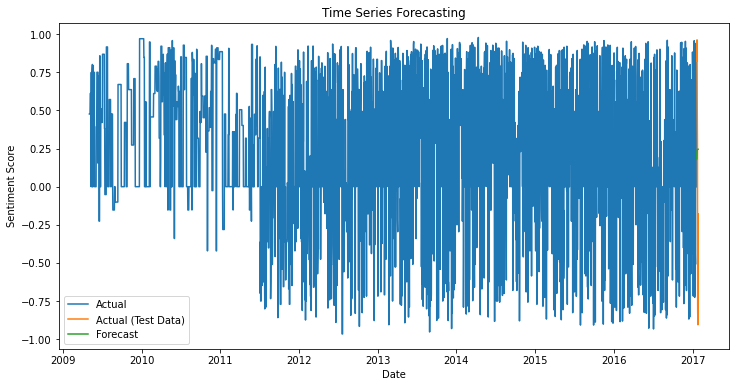

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from cassandra.util import Date



# Set the 'date' column as the index
#df.set_index('date', inplace=True)

# Perform time-series forecasting

# Extract the 'sentiment_score' column as the time series data
time_series_data = df['sentiment_score']

# Remove duplicate index values
time_series_data = time_series_data[~time_series_data.index.duplicated(keep='first')]

# Create a new daily date range
date_range = pd.date_range(start=time_series_data.index.min(), end=time_series_data.index.max(), freq='D')

# Reindex the time series data with the new date range
time_series_data = time_series_data.reindex(date_range)

# Handle missing values in the training data
train_data = time_series_data[:-7]  # Use all data except the last 7 days for training
train_data = train_data.fillna(method='ffill')  # Forward fill missing values

# Split the data into train and test sets
test_data = time_series_data[-7:]  # Use the last 7 days for testing

# Perform time series decomposition
decomposition = seasonal_decompose(train_data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(train_data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Perform ARIMA modeling and forecasting
model = ARIMA(train_data, order=(1, 0, 0))  # Adjust the order based on your data
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)  # Forecast for the next 7 days

# Print the forecasts
print(forecast)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Actual')
plt.plot(test_data.index, test_data, label='Actual (Test Data)')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()
